In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
pd.pandas.set_option('display.max_columns',None)

In [37]:
train_a = pd.read_csv('train.csv')
test_a = pd.read_csv('test.csv')

# Concatenate into one data set
data_a = pd.concat([train_a, test_a]).reset_index(drop=True)

# Set Sale Price
sp = train_a['SalePrice'].reset_index(drop=True)

# Drop dependant variable from whole dataset
data_a.drop(columns=['SalePrice'], inplace=True)

print(f'train_a: {train_a.shape[0]} rows and {train_a.shape[1]} columns.\n')
print(f'test_a: {test_a.shape[0]} rows and {test_a.shape[1]} columns.\n')
print(f'data_a: {data_a.shape[0]} rows and {data_a.shape[1]} columns.')

train_a: 1460 rows and 81 columns.

test_a: 1459 rows and 80 columns.

data_a: 2919 rows and 80 columns.


<AxesSubplot:>

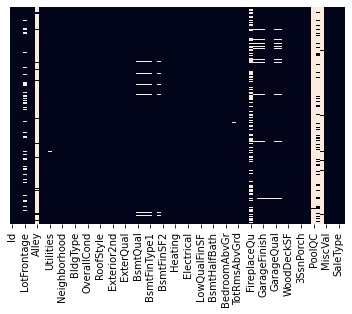

In [38]:
sns.heatmap(data_a.isnull(),yticklabels=False,cbar=False) # Heatmap view of all null values in DF

In [39]:
# Drop columns with more than 45% missing data 
c_drop = []
for c in data_a:
  if data_a[c].isnull().sum() / len(data_a) >= 0.4:
    c_drop.append(c)
data_a.drop(c_drop, axis=1, inplace=True)

print(f'{len(c_drop)} columns dropped, the full dataset now contains {data_a.shape[1]} variables.')

5 columns dropped, the full dataset now contains 75 variables.


In [40]:
# Replace the Nan values with the median for the numerical 
# columns and normalize the data using MinMaxScaler
mmscaler = MinMaxScaler() # Define Object

columns = data_a.columns.values   # Define Object, all variable names in numpy array format
for c in columns:                 # if the dtypes of the variables in the full dataframe are an integer or float,
  if data_a[c].dtype == np.int64 or data_a[c].dtype == np.float64:    # then fill null values with the median value
    data_a[c] = data_a[c].fillna(data_a[c].median())
    data_a[c] = mmscaler.fit_transform(np.array(data_a[c]).reshape(-1,1))  # fit and tranform the columns through minmaxscaler to normalize

# Print the updated data  
data_a.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.000000,0.235294,RL,0.150685,0.033420,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,0.666667,0.500,0.949275,0.883333,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.12250,Gd,TA,PConc,Gd,TA,No,GLQ,0.125089,Unf,0.0,0.064212,0.140098,GasA,Ex,Y,SBrkr,0.109641,0.413559,0.0,0.259231,0.333333,0.0,0.50,0.5,0.375,0.333333,Gd,0.461538,Typ,0.00,Attchd,0.346154,RFn,0.4,0.368280,TA,TA,Y,0.000000,0.082210,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,WD,Normal
1,0.000343,0.000000,RL,0.202055,0.038795,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,0.555556,0.875,0.753623,0.433333,Gable,CompShg,MetalSd,MetalSd,None,0.00000,TA,TA,CBlock,Gd,TA,Gd,ALQ,0.173281,Unf,0.0,0.121575,0.206547,GasA,Ex,Y,SBrkr,0.194917,0.000000,0.0,0.174830,0.000000,0.5,0.50,0.0,0.375,0.333333,TA,0.307692,Typ,0.25,Attchd,0.259615,RFn,0.4,0.309140,TA,TA,Y,0.209270,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,WD,Normal
2,0.000685,0.235294,RL,0.160959,0.046507,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,0.666667,0.500,0.934783,0.866667,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.10125,Gd,TA,PConc,Gd,TA,Mn,GLQ,0.086109,Unf,0.0,0.185788,0.150573,GasA,Ex,Y,SBrkr,0.123083,0.419370,0.0,0.273549,0.333333,0.0,0.50,0.5,0.375,0.333333,Gd,0.307692,Typ,0.25,Attchd,0.339744,RFn,0.4,0.408602,TA,TA,Y,0.000000,0.056604,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,WD,Normal
3,0.001028,0.294118,RL,0.133562,0.038561,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,0.666667,0.500,0.311594,0.333333,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00000,TA,TA,BrkTil,TA,Gd,No,ALQ,0.038271,Unf,0.0,0.231164,0.123732,GasA,Gd,Y,SBrkr,0.131695,0.366102,0.0,0.260550,0.333333,0.0,0.25,0.0,0.375,0.333333,Gd,0.384615,Typ,0.25,Detchd,0.330128,Unf,0.6,0.431452,TA,TA,Y,0.000000,0.047170,0.268775,0.0,0.0,0.0,0.0,0.090909,0.00,WD,Abnorml
4,0.001371,0.235294,RL,0.215753,0.060576,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,0.777778,0.500,0.927536,0.833333,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.21875,Gd,TA,PConc,Gd,TA,Av,GLQ,0.116052,Unf,0.0,0.209760,0.187398,GasA,Ex,Y,SBrkr,0.170342,0.509927,0.0,0.351168,0.333333,0.0,0.50,0.5,0.500,0.333333,Gd,0.538462,Typ,0.25,Attchd,0.336538,RFn,0.6,0.561828,TA,TA,Y,0.134831,0.113208,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,WD,Normal


12 columns dropped, the full dataset now contains 63 variables.


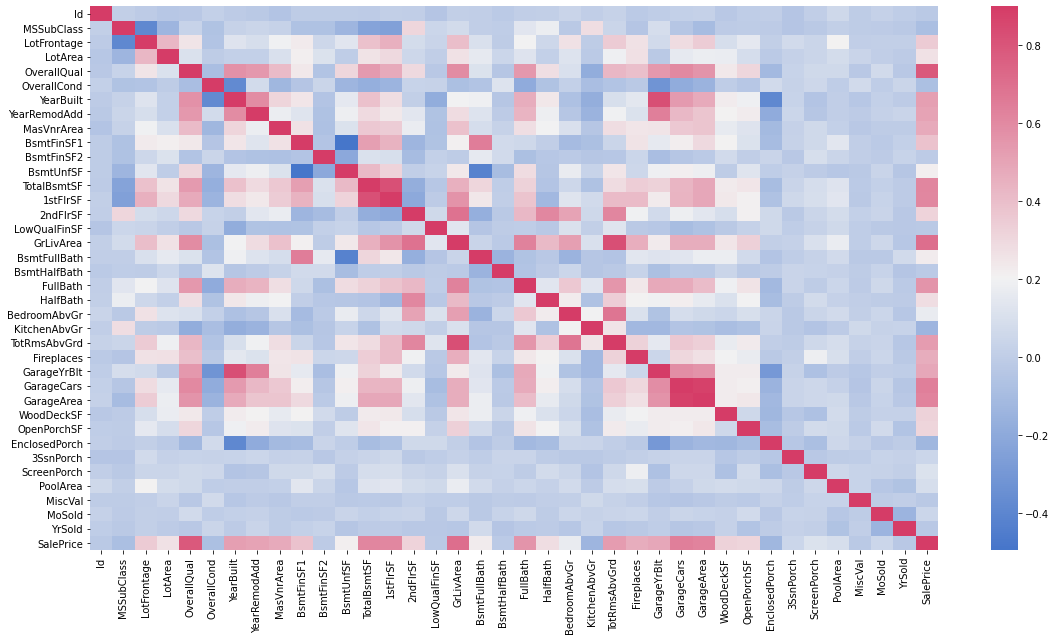

In [41]:
# Calculate the correlation of the numerical variables with the Sale Price 
# Use the training dataset that inludes the Sale Price variable  

corr = train_a.corr()
plt.subplots(figsize=(19,10))
cmap = sns.diverging_palette(255, 1, as_cmap=True)
sns.heatmap(corr, vmax=0.9, cmap = cmap, square=False)

cols_to_drop = []
# Get the correlation of the dependent variable with the rest of the features
sale_price_corr = train_a.corr()['SalePrice'][:-1] 

# Drop all the columns from the full data that correlate < |0.12| with the sale price, 
# since will add little value to the model 
for column,row in sale_price_corr.iteritems():
  if abs(float(row)) < 0.12:
    cols_to_drop.append(column)
data_a.drop(cols_to_drop, axis=1, inplace=True)

print(f'{len(cols_to_drop)} columns dropped, the full dataset now contains {data_a.shape[1]} variables.')

In [42]:
# Drop the categorical variables that have more than 6 unique categorical classes
count = 0 
columns = data_a.columns.values
for c in columns:
  if data_a[c].dtype not in (np.int64, np.float64) and data_a[c].nunique() > 6:
    count += 1 
    data_a.drop(c, axis = 1, inplace = True)

print(f'{count} columns dropped, the full dataset now comprises of {data_a.shape[1]} variables.')

9 columns dropped, the full dataset now comprises of 54 variables.


In [43]:
# Replace the rest of the null values in the remaining categories with the most frequent value in that column
data_a = data_a.fillna(data_a.mode().iloc[0])
data_a.shape
data_a

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,BldgType,OverallQual,YearBuilt,YearRemodAdd,RoofStyle,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,SaleCondition
0,RL,0.150685,0.033420,Pave,Reg,Lvl,AllPub,Inside,Gtl,1Fam,0.666667,0.949275,0.883333,Gable,BrkFace,0.12250,Gd,TA,PConc,Gd,TA,No,GLQ,0.125089,Unf,0.064212,0.140098,GasA,Ex,Y,SBrkr,0.109641,0.413559,0.259231,0.333333,0.50,0.5,0.375,0.333333,Gd,0.461538,0.00,Attchd,0.346154,RFn,0.4,0.368280,TA,TA,Y,0.000000,0.082210,0.000000,Normal
1,RL,0.202055,0.038795,Pave,Reg,Lvl,AllPub,FR2,Gtl,1Fam,0.555556,0.753623,0.433333,Gable,None,0.00000,TA,TA,CBlock,Gd,TA,Gd,ALQ,0.173281,Unf,0.121575,0.206547,GasA,Ex,Y,SBrkr,0.194917,0.000000,0.174830,0.000000,0.50,0.0,0.375,0.333333,TA,0.307692,0.25,Attchd,0.259615,RFn,0.4,0.309140,TA,TA,Y,0.209270,0.000000,0.000000,Normal
2,RL,0.160959,0.046507,Pave,IR1,Lvl,AllPub,Inside,Gtl,1Fam,0.666667,0.934783,0.866667,Gable,BrkFace,0.10125,Gd,TA,PConc,Gd,TA,Mn,GLQ,0.086109,Unf,0.185788,0.150573,GasA,Ex,Y,SBrkr,0.123083,0.419370,0.273549,0.333333,0.50,0.5,0.375,0.333333,Gd,0.307692,0.25,Attchd,0.339744,RFn,0.4,0.408602,TA,TA,Y,0.000000,0.056604,0.000000,Normal
3,RL,0.133562,0.038561,Pave,IR1,Lvl,AllPub,Corner,Gtl,1Fam,0.666667,0.311594,0.333333,Gable,None,0.00000,TA,TA,BrkTil,TA,Gd,No,ALQ,0.038271,Unf,0.231164,0.123732,GasA,Gd,Y,SBrkr,0.131695,0.366102,0.260550,0.333333,0.25,0.0,0.375,0.333333,Gd,0.384615,0.25,Detchd,0.330128,Unf,0.6,0.431452,TA,TA,Y,0.000000,0.047170,0.268775,Abnorml
4,RL,0.215753,0.060576,Pave,IR1,Lvl,AllPub,FR2,Gtl,1Fam,0.777778,0.927536,0.833333,Gable,BrkFace,0.21875,Gd,TA,PConc,Gd,TA,Av,GLQ,0.116052,Unf,0.209760,0.187398,GasA,Ex,Y,SBrkr,0.170342,0.509927,0.351168,0.333333,0.50,0.5,0.500,0.333333,Gd,0.538462,0.25,Attchd,0.336538,RFn,0.6,0.561828,TA,TA,Y,0.134831,0.113208,0.000000,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,RM,0.000000,0.002973,Pave,Reg,Lvl,AllPub,Inside,Gtl,Twnhs,0.333333,0.710145,0.333333,Gable,None,0.00000,TA,TA,CBlock,TA,TA,No,Unf,0.000000,Unf,0.233733,0.089362,GasA,Gd,Y,SBrkr,0.044528,0.264407,0.142803,0.000000,0.25,0.5,0.375,0.333333,TA,0.230769,0.00,Attchd,0.269231,Unf,0.0,0.000000,TA,TA,Y,0.000000,0.000000,0.000000,Normal
2915,RM,0.000000,0.002776,Pave,Reg,Lvl,AllPub,Inside,Gtl,TwnhsE,0.333333,0.710145,0.333333,Gable,None,0.00000,TA,TA,CBlock,TA,TA,No,Rec,0.044649,Unf,0.125856,0.089362,GasA,TA,Y,SBrkr,0.044528,0.264407,0.142803,0.000000,0.25,0.5,0.375,0.333333,TA,0.307692,0.00,CarPort,0.240385,Unf,0.2,0.192204,TA,TA,Y,0.000000,0.032345,0.000000,Abnorml
2916,RL,0.476027,0.087406,Pave,Reg,Lvl,AllPub,Inside,Gtl,1Fam,0.444444,0.637681,0.766667,Gable,None,0.00000,TA,TA,CBlock,TA,TA,No,ALQ,0.216867,Unf,0.000000,0.200327,GasA,Ex,Y,SBrkr,0.186936,0.000000,0.167671,0.333333,0.25,0.0,0.500,0.333333,TA,0.384615,0.25,Detchd,0.208333,Unf,0.4,0.387097,TA,TA,Y,0.332865,0.000000,0.000000,Abnorml
2917,RL,0.140411,0.042726,Pave,Reg,Lvl,AllPub,Inside,Gtl,1Fam,0.444444,0.869565,0.700000,Gable,None,0.00000,TA,TA,PConc,Gd,TA,Av,GLQ,0.059709,Unf,0.246147,0.149264,GasA,TA,Y,SBrkr,0.133585,0.000000,0.119819,0.000000,0.25,0.0,0.375,0.333333,TA,0.307692,0.00,Attchd,0.269231,Unf,0.0,0.000000,TA,TA,Y,0.056180,0.043127,0.000000,Normal


In [44]:
# Label / one-hot encode the categorical variables
# One-hot encode the columns that have > 2 categorical variables
# Label-encode the columns that have only 2 categorical variables 

labelencoder = LabelEncoder() # Set LabelEncoder
cols_to_drop = []

columns = data_a.columns.values # Set 
for c in columns:
    if data_a[c].dtype not in (np.int64, np.float64) and data_a[c].nunique() > 2: 
      dummies = pd.get_dummies(data_a[c], prefix = str(c))
      cols_to_drop.append(c)
      data_a = pd.concat([data_a, dummies], axis = 1)
    elif data_a[c].dtype not in (np.int64, np.float64) and data_a[c].nunique() < 3: 
      data_a[c] = labelencoder.fit_transform(data_a[c])
      cols_to_drop.append(c)

data_a.drop(cols_to_drop, axis = 1, inplace = True)
print(f'The new dataframe contains {data_a.shape[0]} rows and {data_a.shape[1]} columns.\n')

The new dataframe contains 2919 rows and 148 columns.



In [45]:
# Split preprocessed data into train and test
train_b = data_a[:train_a.shape[0]] 
test_b = data_a[train_a.shape[0]:] 

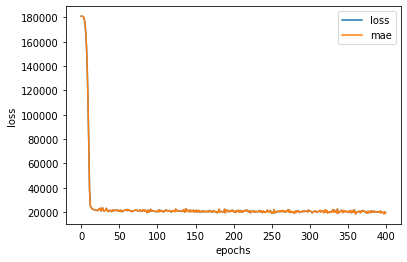

array([118424.25 , 152476.23 , 178414.67 , ..., 166681.6  , 117949.625,
       215894.72 ], dtype=float32)

In [46]:
#Set random seed
tf.random.set_seed(5)

model = tf.keras.Sequential([
                            tf.keras.layers.Dense(1000), 
                            tf.keras.layers.BatchNormalization(), 
                            tf.keras.layers.Dense(100), 
                            tf.keras.layers.Dense(100),
                            tf.keras.layers.Dropout(0.1), 
                            tf.keras.layers.Dense(1) 
])

# Compile the model
model.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0003), 
                          metrics=['mae'])

# Fit the model and save the history 
history = model.fit(train_b,sp, epochs=400, verbose=0)

# Plot the model trained for 400 total epochs loss curves
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

DNN_predictions = model.predict(test_b)
DNN_predictions = tf.squeeze(DNN_predictions, axis = 1)
DNN_predictions = np.array(DNN_predictions)
DNN_predictions

In [48]:
from xgboost import XGBRegressor

xgboost = XGBRegressor(learning_rate=0.008,
                       n_estimators=6000,
                       max_depth=8,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=5)

xgb = xgboost.fit(train_b,sp)
training_accuracy = xgb.score(train_b,sp)
xgb_predictions = xgb.predict(test_b)

Training accuracy: 100.00%


In [52]:
predictions = [(xgb_pred + DNN_pred) / 2 for xgb_pred, DNN_pred in zip(xgb_predictions, DNN_predictions)]

In [53]:
submission = pd.DataFrame({'ID':test_a['Id'],'SalePrice':predictions})
submission.to_csv('submission2.csv',index = False)
submission

,ID,SalePrice
0,1461,119615.164062
1,1462,156092.781250
2,1463,182607.109375
3,1464,186221.000000
4,1465,180916.218750
...,...,...
1454,2915,71881.710938
1455,2916,71913.359375
1456,2917,161148.531250
1457,2918,116365.625000
